In [1]:
%reload_ext autoreload
%autoreload

In [2]:
import xarray as xr
from datetime import datetime
import numpy as np
from datetime import timedelta
from climpy.transform.condition import MaskArea, ThresholdQuantile, ConnectStructure, AverageArea
from climpy.transform.hazard import PointHazard
from climpy.transform.select import EventSelector, TimeBetweenEvents
from climpy.transform.criterion import Criterion
from climpy.transform.link import ValueOverTimeInterval, ValueAtTimeOffset

import matplotlib.pyplot as plt

In [3]:
catch_id = 6337060

shp_path = f"/data/compoundx/GRDC_runoff/Xie_bnd/individual_shp/{catch_id}.geojson"
input_dir = '/data/compoundx/causal_flood/grdc/GRDC-Daily.nc'
runoff = xr.open_dataset(input_dir)["runoff_mean"].sel(id = catch_id)
met_path = f"/data/compoundx/causal_flood/basins_gridded/observations_meteorological/{catch_id}/"
tavg_data = xr.open_dataset(met_path + "tavg.nc")["tavg"]
pre_data = xr.open_dataset(met_path + "pre.nc")["pre"]

In [28]:
quantile = 0.90
structure = np.array([1,1,1])

flood_criteria = Criterion([
    ThresholdQuantile('>', quantile),
    ConnectStructure(structure)
])

In [29]:
# flood = PointHazard(flood_criteria)
flood_criteria.apply_conditions(runoff)

<xarray.DataArray 'runoff_mean' (time: 78915)>
array([0, 0, 0, ..., 0, 0, 0], dtype=int32)
Coordinates:
  * time     (time) datetime64[ns] 1806-01-01 1806-01-02 ... 2022-01-22
    id       int32 6337060

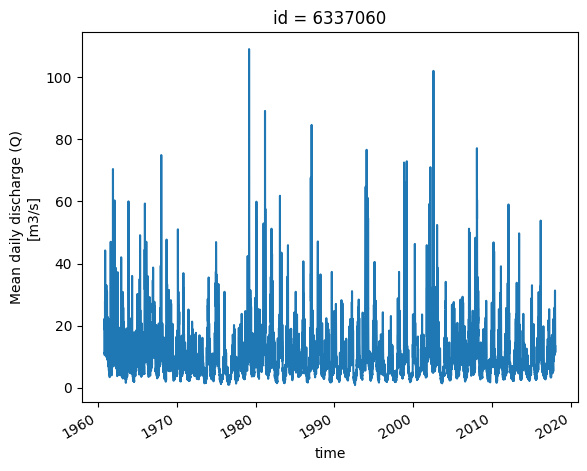

In [18]:
runoff.plot()

In [16]:
event_list = flood.all_events()

317

In [21]:
event = flood.get_event(200)

In [23]:
event.location

<xarray.DataArray 'runoff_mean' (time: 4)>
array([201., 201., 201., 201.])
Coordinates:
  * time     (time) datetime64[ns] 1998-04-09 1998-04-10 1998-04-11 1998-04-12
    id       int32 6337060

In [7]:
event_selected_list = EventSelector(event_list).filter_by_rule(TimeBetweenEvents( '>', timedelta(days=10)))
len(event_selected_list)

265

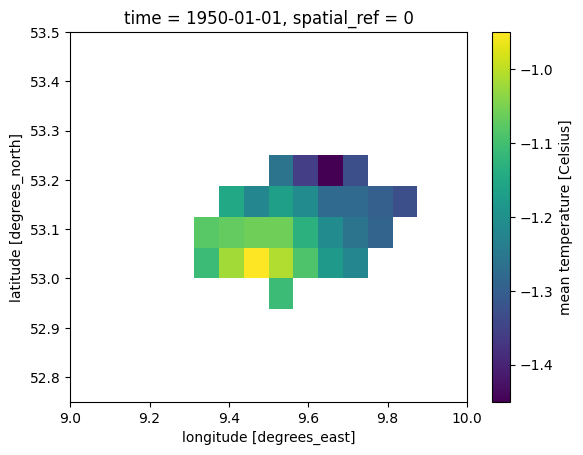

In [26]:

MaskArea(shp_path=shp_path)(tavg_data)[0,:,:].plot()

In [9]:
preprocessing_conditions = Criterion([
    MaskArea(shp_path=shp_path),
    AverageArea(),
])

In [27]:
tavg_processed = preprocessing_conditions.apply_conditions(tavg_data)
pre_processed = preprocessing_conditions.apply_conditions(pre_data)

In [11]:
link = ValueAtTimeOffset(timedelta(days=-6))
link.on_events(event_list=event_selected_list)
t_avg_7day_before = link.get_values(tavg_processed)

In [12]:
link = ValueOverTimeInterval(timedelta(days=-6))
link.on_events(event_list=event_selected_list)
pre_last_7days = link.get_values(pre_processed)

In [13]:
pre_last_7days[100]

<xarray.DataArray 'pre' (time: 7)>
array([ 0.        ,  5.4392858 , 13.99642878,  5.41785722,  9.432143  ,
        1.46428574,  0.        ])
Coordinates:
  * time         (time) datetime64[ns] 1982-02-27 1982-02-28 ... 1982-03-05
    spatial_ref  int64 0